In [1]:
# Dependencies
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt, patches
from utils.config import load_config_nb
from evaluation.policy_evaluation import evaluate_policy
from nocturne.envs.base_env import BaseEnv
import datetime
import pandas as pd
import pickle
sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (6, 6)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

### Configurations

In [2]:
BINS = [-1, 0, 1, 2, float('inf')]
LABELS = ['0', '1', '2', '3+']

### Helper functions

In [3]:
def step_through_scene(env, use_expert_actions, scene_name=None, max_steps=80, verbose=False):
    
    pos_arr = np.zeros((max_steps, 2))
    speed_arr = np.zeros((max_steps))
    heading_arr = np.zeros((max_steps))
    action_acc = np.zeros(max_steps)
    action_ste = np.zeros(max_steps)

    # RESET
    obs_dict = env.reset(filename=scene_name)
    
    # TAKE VEHICLE
    veh_obj = env.controlled_vehicles[0]
    print(f'Controlling veh_id: {veh_obj.id}, is_av: {veh_obj.is_av} | init_speed: {veh_obj.speed}')

    for t_idx in range(max_steps):
        
        #print(t_idx)
        
        action_dict = {}
        if use_expert_actions:
            expert_action = env.scenario.expert_action(veh_obj, env.step_num)
            action_dict[veh_obj.id] = expert_action
        else:   
            # Use expert teleports
            veh_obj.expert_control = True       
            expert_action = None  
            
        if expert_action is not None:
            action_acc[t_idx] = expert_action.acceleration
            action_ste[t_idx] = expert_action.steering
            
        if use_expert_actions:
            speed_arr[t_idx] = veh_obj.speed
            pos_arr[t_idx, 0] = veh_obj.position.x
            pos_arr[t_idx, 1] = veh_obj.position.y
            heading_arr[t_idx] = veh_obj.heading
            
        else:
            speed_arr[t_idx] = env.scenario.expert_speed(veh_obj, env.step_num)
            pos_arr[t_idx, 0] = env.scenario.expert_position(veh_obj, env.step_num).x
            pos_arr[t_idx, 1] = env.scenario.expert_position(veh_obj, env.step_num).y
            heading_arr[t_idx] = env.scenario.expert_heading(veh_obj, env.step_num)
            
        #print(env.scenario.expert_position(veh_obj, env.step_num).x)
    
        if use_expert_actions and expert_action is None:
            print(f'expert_action is None at time_step: {env.step_num}')
            continue 
        
        # Step
        obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
        
        if done_dict['__all__']:
            print(f'Done at: {env.step_num}, info: {info_dict}')
            break
        
    return veh_obj, t_idx, pos_arr, speed_arr, action_acc, action_ste, heading_arr

### Inspect trajectories

In [74]:
# Load config and set data path to new data folder
env_config = load_config_nb("env_config")
env_config.data_path = "../data/train_no_tl/"
env_config.num_files = 1000
env_config.use_av_only = False
env_config.max_num_vehicles = 1

# Make environment
env = BaseEnv(env_config)

In [75]:
scene_name = np.random.choice(env.files)

print(f'scene: {scene_name}')

# Step through scene in EXPERT CONTROL mode
veh_obj, t_done, pos, speed, _, _, heading = step_through_scene(
    env=env, scene_name=scene_name, use_expert_actions=False, 
)

scene: tfrecord-00363-of-01000_49.json
Controlling veh_id: 35, is_av: False | init_speed: 1.562530517578125
Done at: 11, info: defaultdict(<class 'dict'>, {35: {'goal_achieved': True, 'collided': False, 'veh_veh_collision': False, 'veh_edge_collision': False}})


In [76]:
# Step through scene USING EXPERT ACTIONS
veh_obj, t_done_exp, pos_exp, speed_exp, action_acc_exp, action_ste_exp, heading_exp = step_through_scene(
    env=env, scene_name=scene_name, use_expert_actions=True, 
)

Controlling veh_id: 14, is_av: False | init_speed: 14.749101638793945
Done at: 29, info: defaultdict(<class 'dict'>, {14: {'goal_achieved': True, 'collided': False, 'veh_veh_collision': False, 'veh_edge_collision': False}})


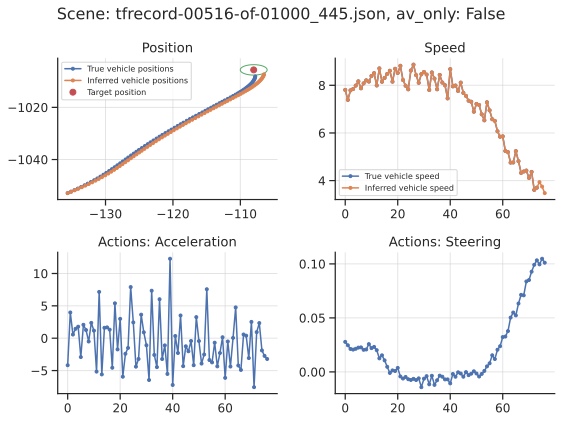

In [264]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle(f'Scene: {scene_name}, av_only: {veh_obj.is_av}')

axs[0, 0].set_title('Position')    
axs[0, 0].plot(pos[:t_done, 0], pos[:t_done, 1], '.-', label='True vehicle positions')
axs[0, 0].plot(pos_exp[:t_done_exp, 0], pos_exp[:t_done_exp, 1], '.-', label='Inferred vehicle positions')
axs[0, 0].plot(veh_obj.target_position.x, veh_obj.target_position.y, 'ro', label='Target position')
target_position = (veh_obj.target_position.x, veh_obj.target_position.y)
circle = plt.Circle(target_position, 2, color='g', fill=False)
axs[0, 0].add_patch(circle)
axs[0, 0].legend(fontsize=8, facecolor='white')
axs[0, 0].grid(alpha=0.5)  

# Plot speed
axs[0, 1].set_title('Speed')    
axs[0, 1].plot(speed[:t_done], '.-', label='True vehicle speed')
axs[0, 1].plot(speed_exp[:t_done_exp], '.-', label='Inferred vehicle speed')
axs[0, 1].legend(fontsize=8, facecolor='white')
axs[0, 1].grid(alpha=0.5)  

# Plot acceleration
axs[1, 0].set_title('Actions: Acceleration')
axs[1, 0].plot(action_acc_exp[:t_done_exp], '.-')
axs[1, 0].grid(alpha=0.5)  

# Plot steering
axs[1, 1].set_title('Actions: Steering')
axs[1, 1].plot(action_ste_exp[:t_done_exp], '.-')
axs[1, 1].grid(alpha=0.5)  
# Set titles and labels
plt.tight_layout()
sns.despine()

# generate date stamp
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M")

# Save figure in imitation learning folder
fig.savefig(f'../evaluation/figures/il/{scene_name}_trajs.pdf', format='pdf', bbox_inches='tight')

### Dataset

In [7]:
# Load intersection info
with open('../evaluation/scene_info/info_dict_test_no_tl', 'rb') as handle:
    test_scene_to_paths_dict = pickle.load(handle)

# Taking the first X items from train_scene_to_paths_dict
first_10_000_items = list(test_scene_to_paths_dict.items())[:10_000]

# Initialize an empty DataFrame
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths', 'min_step_diff'])

# Populate the DataFrame with the first 500 items
for traffic_scene, data in first_10_000_items:
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']
    step_diff = data['min_step_diff']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the DataFrame
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths, step_diff)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths', 'min_step_diff'])])

# Calculate the number of vehicles in each scene
df_intersect['vehs_in_scene'] = df_intersect.groupby('traffic_scene')['veh_id'].transform('nunique')

/tmp/ipykernel_2405997/1881283300.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths, step_diff)),


In [24]:
df_intersect['intersecting_paths'].value_counts()

intersecting_paths
0     53013
1     12829
2      3778
3      1172
4       395
5       189
6        83
7        80
8        38
9        25
11       15
10       15
12        7
13        6
14        3
19        1
21        1
17        1
15        1
16        1
Name: count, dtype: int64

In [25]:
latex_output = df_intersect['vehs_in_scene'].describe().to_latex(float_format="%.2f")
print(latex_output)


\begin{tabular}{lr}
\toprule
 & vehs_in_scene \\
\midrule
count & 71653.00 \\
mean & 12.63 \\
std & 9.46 \\
min & 1.00 \\
25% & 6.00 \\
50% & 10.00 \\
75% & 17.00 \\
max & 58.00 \\
\bottomrule
\end{tabular}



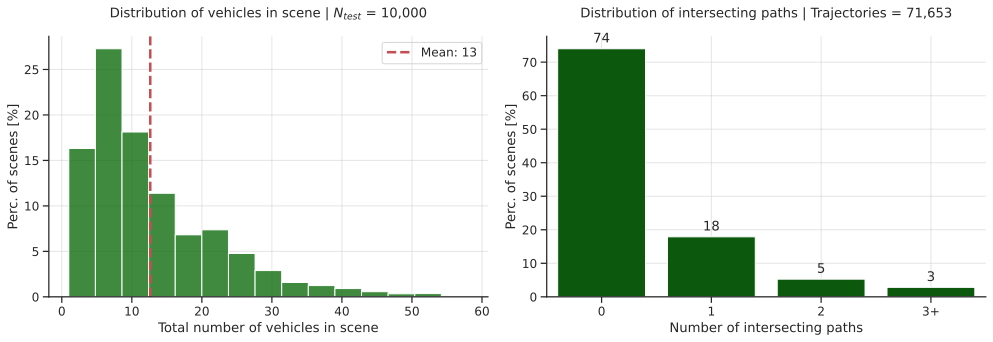

In [15]:
# Assuming df_intersect contains the DataFrame with 'vehs_in_scene' and 'intersecting_paths' columns
df = df_intersect.reset_index()
df['int_cat'] = pd.cut(df['intersecting_paths'], bins=BINS, labels=LABELS, include_lowest=True,)

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 2: Histogram for vehs_in_scene
sns.histplot(df['vehs_in_scene'], bins=15, stat='percent', ax=axes[0], color='darkgreen')
axes[0].set_title('Distribution of vehicles in scene | $N_{test}$ = 10,000',  y=1.05)
axes[0].set_xlabel('Total number of vehicles in scene')
axes[0].set_ylabel('Perc. of scenes [%]')
axes[0].grid(True, alpha=0.5)
axes[0].axvline(df['vehs_in_scene'].mean(), color='r', linestyle='--', lw=2.5, label=f'Mean: {df["vehs_in_scene"].mean():.0f}')
axes[0].legend()

# Plot 1: Countplot for intersecting paths
ax1 = sns.countplot(x='int_cat', stat ='percent', data=df, ax=axes[1], color='darkgreen')
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax1.set_title(f'Distribution of intersecting paths | Trajectories = {df_intersect.shape[0]:,}', y=1.05)
ax1.set_ylabel('Perc. of scenes [%]')
ax1.set_xlabel('Number of intersecting paths')
ax1.grid(True, alpha=0.5)
sns.despine()

plt.tight_layout()
plt.show()

fig.savefig(f'../evaluation/figures/dataset/test_dist.pdf', format='pdf', bbox_inches='tight')